In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pyaudi import gdual
from pyaudi import sin, cos, tanh, exp, log

## Logistic regression with Newton's method

We define the input dimension (5) and the desired order for the derivatives (2):

In [2]:
n_inputs = 5
order = 2

We create symbolic variables for the initial weights with values drawn from $\mathcal N(0.01,1)$

#### Symbolic variables

In [3]:
def initialize_weights(n_inputs, order):

    weights = []
    for unit in range(n_inputs+1):
                symname = 'w_{{{0}}}'.format(unit)
                w = gdual(0.01*np.random.randn(), symname , order)
                weights.append(w)
          
    return weights

initial_weights = initialize_weights(n_inputs,order)

In [4]:
weights = initial_weights.copy()

#### Logistic regression as a gdual expression

We create a function for the sigmoid (which accepts gduals) and the logistic regression function $g(x,w) = \sigma(sum(x \cdot w'+b))$

In [5]:
def sig(x):
    return 1/(1+exp(-1*x))

def logistic_regression_f(inputs, w):
    
    unit_output = w[0]
    for unit in range(len(w)-1):
        unit_output += inputs[unit]*w[unit+1]           
    return sig(unit_output)

The new function can be used to compute the output of the network given any input:

In [6]:
x = np.random.rand(n_inputs)

N = logistic_regression_f(x, weights)
print('N(x) = {0}'.format(N.constant_cf))
N

N(x) = 0.4955793909502224


0.0802382*dw_{2}+0.000589098*dw_{2}*dw_{5}+0.000528621*dw_{2}*dw_{4}+0.186276*dw_{4}+0.495579+0.000613607*dw_{4}**2+3.60873e-05*dw_{3}**2+0.000202006*dw_{1}*dw_{5}+0.000181268*dw_{1}*dw_{4}+0.0275143*dw_{1}+0.000399394*dw_{0}*dw_{3}+0.000331661*dw_{3}*dw_{5}+0.000709404*dw_{0}*dw_{2}+0.000128197*dw_{2}*dw_{3}+1.33873e-05*dw_{1}**2+0.045174*dw_{3}+7.80811e-05*dw_{1}*dw_{2}+0.000297613*dw_{3}*dw_{4}+0.000113852*dw_{2}**2+0.00110507*dw_{0}**2+...

#### Loss function

The training process will seek to minimize a loss function corresponding to the log-likelihood:
$$l= -y\log(N(x))-(1-y)\log(1-N(x))$$

In [7]:
def loss_f(N,y):
        
    #To avoid log(0) being -inf: 
    if abs(N.constant_cf - y) == 1:
        if y == 1:
            return -1*log( N + 1e-10)
        else:
            return -1*log((1-N) + 1e-10)
            

    return -y*log(N) - (1-y)*log(1-N)

In [8]:
y = 1

loss = loss_f(N, y)
print('loss = {0}'.format(loss.constant_cf))
loss

loss = 0.702027714130889


-0.161908*dw_{2}+0.0666308*dw_{2}*dw_{5}+0.0597905*dw_{2}*dw_{4}-0.375875*dw_{4}+0.702028+0.069403*dw_{4}**2+0.00408171*dw_{3}**2+0.0228482*dw_{1}*dw_{5}+0.0205026*dw_{1}*dw_{4}-0.0555194*dw_{1}+0.045174*dw_{0}*dw_{3}+0.0375131*dw_{3}*dw_{5}+0.0802382*dw_{0}*dw_{2}+0.0144999*dw_{2}*dw_{3}+0.00151419*dw_{1}**2-0.091154*dw_{3}+0.00883148*dw_{1}*dw_{2}+0.033662*dw_{3}*dw_{4}+0.0128774*dw_{2}**2+0.12499*dw_{0}**2+...

The function loss_f accepts a gdual (N) and a float (y) and the output still a gdual, which will make it possible to compute its derivatives wrt any of the parameters of the network:

In [9]:
for symbol in loss.symbol_set[-10:]:
    print(symbol)    

w_{0}
w_{1}
w_{2}
w_{3}
w_{4}
w_{5}


To compute $\frac{\partial l}{\partial w_0}$:

In [10]:
dev_idx = [0]*loss.symbol_set_size
dev_idx[0] = 1
d = loss.get_derivative(dev_idx)
print('The 1st order partial derivative of loss wrt {0} is: {1:.2f}'.format(loss.symbol_set[0], d))

The 1st order partial derivative of loss wrt w_{0} is: -0.50


To compute $\frac{\partial^ 2 l}{\partial w_0 \partial w_1}$:

In [11]:
dev_idx = [0]*loss.symbol_set_size
dev_idx[0] = 1
dev_idx[1] = 1
d = loss.get_derivative(dev_idx)
print('The 2nd order partial derivative of loss wrt ({0},{1}) is: {2:.2f}'.format(loss.symbol_set[0],
                                                                    loss.symbol_set[1], d))

The 2nd order partial derivative of loss wrt (w_{0},w_{1}) is: 0.03


#### Data

We will create a (random) projection of the n-dimensional data to two dimensions so it can be easily visualized

In [12]:
proj_ws = np.random.rand(n_inputs,2)

def vis_proj(x):
    x = np.asarray(x)
    x = x.reshape(-1,n_inputs)
    np.random.seed(0)    
    return np.dot(x,proj_ws)

And we create some labels with some noisey 

In [13]:
def y_f(x):
    x = vis_proj(x)    
    ws = np.asarray([1,0.4]).reshape(2,1)
    y = np.sum(np.dot(x, ws),1)
    y += np.random.randn(y.shape[0])
    y[y>0] = 1
    y[y<0] = 0
    return y


Finally we create some x,y data points for training and testing the model

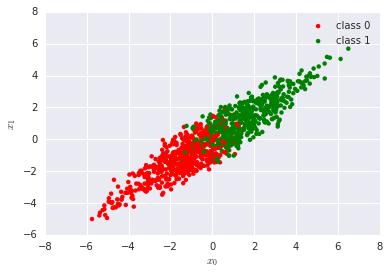

In [14]:
X_train = np.random.rand(500, n_inputs)*5-2.5
X_test  = np.random.rand(1000, n_inputs)*5-2.5

Y_train = y_f(X_train)
Y_test = y_f(X_test)

X_vis = vis_proj(X_test)
for i in range(X_test.shape[0]):
    c = 'red' if Y_test[i] == 0 else 'green'
    
    plt.scatter(X_vis[i,0], X_vis[i,1], c=c, edgecolors='none')
        
plt.legend(['class 0', 'class 1'])
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')

#### Training (gradient descent)

We define a function to compute all first order derivatives of the loss function with respect to the weights

In [15]:
def first_order_devs(loss, w):
    
    num_params = len(w)
    
    devs = np.zeros((num_params))

    for i in range(len(w)):
            if w[i].symbol_set[0] in loss.symbol_set:
                dw_idx = [0]*loss.symbol_set_size                    
                dw_idx[i] = 1
                d = loss.get_derivative(dw_idx)
            else:
                d = 0

            devs[i] = d
            
    return devs

We update the weights with gradient descent using the first order derivatives (and setting a learning rate)

In [16]:
def GD_update(loss, w, lr):
    
    d = first_order_devs(loss, w)
    
    updates = d
    i=0
    for i in range(len(w)):
        w[i] -= updates[i]*lr
    return w

In [17]:
epochs = 20
weights = initial_weights.copy()
gd_loss_history = []


for e in range(epochs):
    
    if 0 == (e%1):
        #Meassures the train accuracy
        loss = 0
        for i in range(X_test.shape[0]):
            N = logistic_regression_f(X_test[i], weights)
            loss += loss_f(N, Y_test[i])
        loss /= X_test.shape[0]        
        print('Epoch {0}: test loss {1}'.format(e, loss.constant_cf))    
        gd_loss_history.append(loss.constant_cf)
        
    loss = 0
    for i in range(X_train.shape[0]):
            N = logistic_regression_f(X_train[i], weights)
            loss += loss_f(N, Y_train[i])   
            
    loss /= X_train.shape[0]
    weights = GD_update(loss, weights, 1)    


Epoch 0: test loss 0.6991967421689679
Epoch 1: test loss 0.47465905375645534
Epoch 2: test loss 0.40026039021814597
Epoch 3: test loss 0.36219103038046957
Epoch 4: test loss 0.33837839664462477
Epoch 5: test loss 0.32182453219704854
Epoch 6: test loss 0.3095469698380997
Epoch 7: test loss 0.30003383615940454
Epoch 8: test loss 0.2924262863593151
Epoch 9: test loss 0.2861955177272437
Epoch 10: test loss 0.28099582272062706
Epoch 11: test loss 0.2765904750854003
Epoch 12: test loss 0.27281128629714624
Epoch 13: test loss 0.2695351187775785
Epoch 14: test loss 0.2666695413028545
Epoch 15: test loss 0.26414369540941784
Epoch 16: test loss 0.2619022727189022
Epoch 17: test loss 0.25990142348801193
Epoch 18: test loss 0.25810590482241563
Epoch 19: test loss 0.25648704800519767


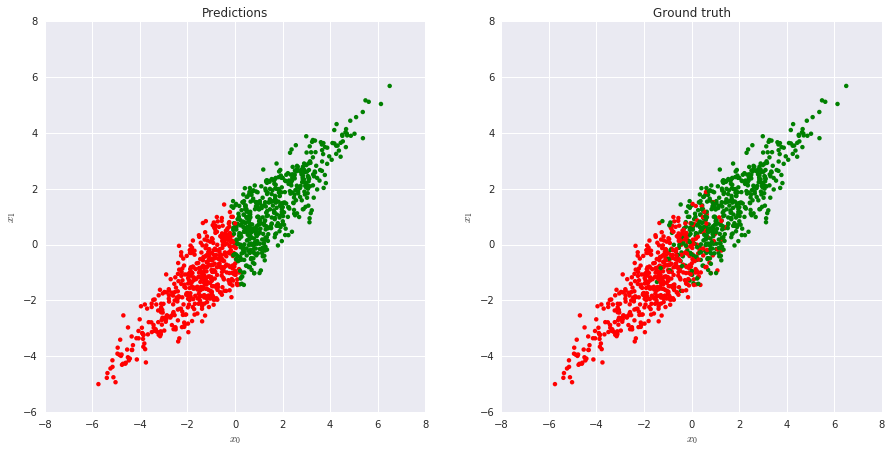

In [18]:
plt.rcParams['figure.figsize'] = (15,7)

X_vis = vis_proj(X_test)
for i in range(X_test.shape[0]):
    N = logistic_regression_f(X_test[i,:], weights)
    pred = N.constant_cf
    
    c = 'red' if N.constant_cf<0.5 else 'green'
    plt.subplot(121)
    plt.scatter(X_vis[i,0], X_vis[i,1], c=c, edgecolors='none')
    
    c = 'red' if Y_test[i]<0.5 else 'green'
    plt.subplot(122)
    
    plt.scatter(X_vis[i,0], X_vis[i,1], c=c, edgecolors='none')
    
    
plt.subplot(121)    
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$') 
plt.title('Predictions')
plt.subplot(122)    
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.title('Ground truth')

#### Training (Newton's method)

In Newton method the weight updates are computed as $\Delta w = H^{-1} \frac{\partial l}{\partial w}$, where $H$ is the hessian (a matrix with all the second order partial derivatives) and $\frac{\partial l}{\partial w}$ is the vector with the first order derivatives.

We define a function to compute the Hessian matrix.

In [19]:
def hessian(loss, w):
    
    num_params = len(w)
    
    partials = np.zeros((num_params, num_params))

    for i in range(len(w)):
        for ii in range(len(w)):
            wi = w[i]
            wii = w[ii]
            if wi.symbol_set[0] in loss.symbol_set and wii.symbol_set[0] in loss.symbol_set:
                idx = loss.symbol_set.index(wi.symbol_set[0])
                iidx = loss.symbol_set.index(wii.symbol_set[0])
                dw_idx = [0]*loss.symbol_set_size                    
                dw_idx[idx] += 1
                dw_idx[iidx] += 1
                partial = loss.get_derivative(dw_idx)
            else:
                partial = 0

            partials[i,ii] = partial
    return partials#np.linalg.inv(partials)


In [20]:
def Newton_update(loss, w):
    

    d = first_order_devs(loss, w)
    H = hessian(loss, w)
    
    #updates = np.dot(H, d.reshape(-1,1))
    updates = np.linalg.lstsq(H,d)[0]
    
    i=0
    for i in range(len(w)):
        w[i] -= updates[i]
    
    return w

We update the weights with gradient descent using the Hessian and the first order derivatives of the loss function with respect to the weights (and biases)

In [21]:
epochs = 10
weights = initial_weights.copy()
newton_loss_history = []

for e in range(epochs):
    
    if 0 == (e%1):
        #Meassures the train accuracy
        loss = 0
        for i in range(X_test.shape[0]):
            N = logistic_regression_f(X_test[i], weights)
            loss += loss_f(N, Y_test[i])
        loss /= X_test.shape[0]        
        print('Epoch {0}: test loss {1}'.format(e, loss.constant_cf))    
        newton_loss_history.append(loss.constant_cf)
        
    loss = 0
    for i in range(X_train.shape[0]):
            N = logistic_regression_f(X_train[i], weights)
            loss += loss_f(N, Y_train[i])   
            
    loss /= X_train.shape[0]
    weights = Newton_update(loss, weights)


Epoch 0: test loss 0.6991967421689679
Epoch 1: test loss 0.353186439112741
Epoch 2: test loss 0.2722434141701537
Epoch 3: test loss 0.24188619325860597
Epoch 4: test loss 0.2345539147298443
Epoch 5: test loss 0.23376145948412283
Epoch 6: test loss 0.23373136168841402
Epoch 7: test loss 0.23373124914354462
Epoch 8: test loss 0.23373124914151158
Epoch 9: test loss 0.23373124914151167


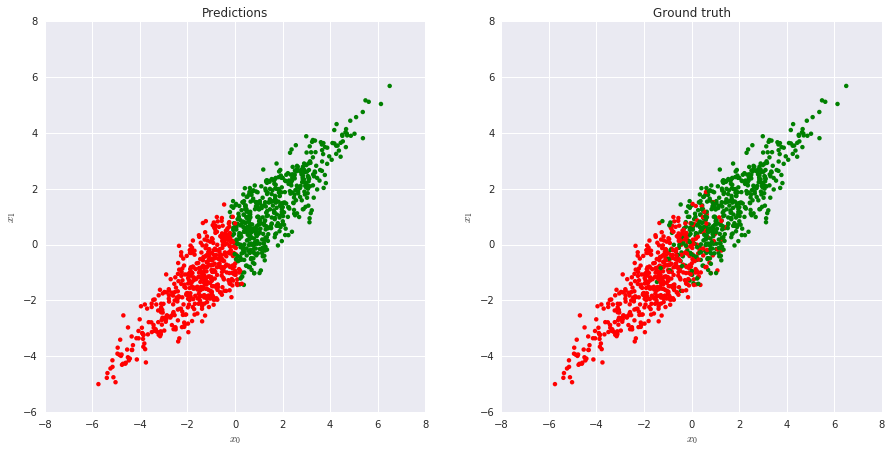

In [22]:
plt.rcParams['figure.figsize'] = (15,7)

X_vis = vis_proj(X_test)
for i in range(X_test.shape[0]):
    N = logistic_regression_f(X_test[i,:], weights)
    pred = N.constant_cf
    
    c = 'red' if N.constant_cf<0.5 else 'green'
    plt.subplot(121)
    plt.scatter(X_vis[i,0], X_vis[i,1], c=c, edgecolors='none')
    
    c = 'red' if Y_test[i]<0.5 else 'green'
    plt.subplot(122)
    
    plt.scatter(X_vis[i,0], X_vis[i,1], c=c, edgecolors='none')
    
    
plt.subplot(121)    
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$') 
plt.title('Predictions')
plt.subplot(122)    
plt.xlabel(r'$x_0$')
plt.ylabel(r'$x_1$')
plt.title('Ground truth')

Newton's method converges faster than gradient descent and does not requiere to set the learning rate.

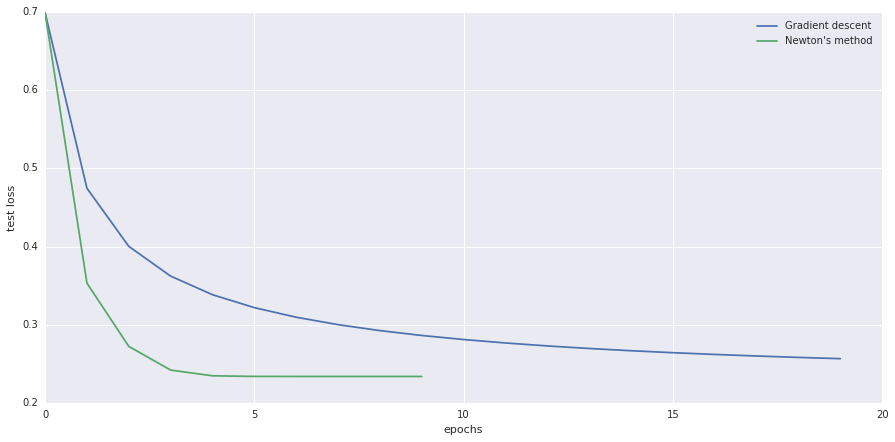

In [23]:
plt.plot(gd_loss_history)
plt.plot(newton_loss_history)

plt.legend(['Gradient descent','Newton\'s method'])
plt.xlabel('epochs')
plt.ylabel('test loss')